In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

In [23]:
train_data=pd.read_csv('train_data_preprocessed.csv',index_col=0)
train_target=pd.read_csv('train_target.csv',index_col=0)
test_data = pd.read_csv('test_data_preprocessed.csv',index_col=0)

In [24]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()

train_data_ssc=ssc.fit_transform(train_data)
test_data_ssc=ssc.transform(test_data)

In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
xgbr = XGBRegressor()

In [26]:
import optuna
def objective(trial,data=train_data_ssc,target=train_target):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target,
                                                        test_size=0.2,random_state=2022,shuffle=True)
    
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': trial.suggest_int('n_estimators',300,3000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    
    model = XGBRegressor(**param)  
    
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_x)
    
    rmse = mean_squared_error(test_y, preds,squared=False)
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10,)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-11-16 11:17:16,955] A new study created in memory with name: no-name-92d2cc2a-6d61-4a05-a8e9-aaa48d281b38
[I 2022-11-16 11:17:19,991] Trial 0 finished with value: 0.1671918787697668 and parameters: {'lambda': 0.27521567042709816, 'alpha': 0.8260630602831394, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.018, 'n_estimators': 1133, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 283}. Best is trial 0 with value: 0.1671918787697668.
[I 2022-11-16 11:17:28,937] Trial 1 finished with value: 0.12007892335745023 and parameters: {'lambda': 0.0284805882396296, 'alpha': 0.43221040956078793, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 2953, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 4}. Best is trial 1 with value: 0.12007892335745023.
[I 2022-11-16 11:17:35,214] Trial 2 finished with value: 0.18299948058447219 and parameters: {'lambda': 0.0026716482844133336, 'alpha': 0.003331510283775185, 'colsample_bytree': 

Number of finished trials: 10
Best trial: {'lambda': 0.0284805882396296, 'alpha': 0.43221040956078793, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.02, 'n_estimators': 2953, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 4}


In [27]:
study.best_value

0.12007892335745023

In [28]:
xgb_best_params=study.best_params
xgb_best_params

In [30]:
xgbr=XGBRegressor(**xgb_best_params)

In [31]:
x_train,x_test,y_train,y_test = train_test_split(train_data_ssc,train_target)

In [32]:
xgbr.fit(x_train,y_train)
y_pred=xgbr.predict(x_test)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_pred,y_test))

In [41]:
sample_sub=pd.read_csv('sample_submission.csv')

In [42]:
xgbr.fit(train_data_ssc,train_target)
y_pred=xgbr.predict(test_data_ssc)

In [43]:
sample_sub['SalePrice'] = np.expm1(y_pred)
sample_sub.set_index('Id').to_csv('_trial.csv')

In [45]:
optuna.visualization.plot_optimization_history(study)

In [46]:
optuna.visualization.plot_param_importances(study)

In [58]:
xgbr.feature_importances_[np.argsort(xgbr.feature_importances_)[::-1][:10]]

array([0.15678062, 0.1466987 , 0.10617106, 0.08033515, 0.06086792,
       0.05465158, 0.04060311, 0.02487822, 0.02374459, 0.013956  ],
      dtype=float32)

In [57]:
train_data.columns[np.argsort(xgbr.feature_importances_)[::-1][:10]]

Index(['OverallQual', 'GarageCars', 'ExterQual', 'FullBath', 'GrLivArea',
       'MSZoning_C (all)', 'Fireplaces', 'CentralAir_Y', 'CentralAir_N',
       'KitchenQual'],
      dtype='object')

<Figure size 1400x700 with 0 Axes>

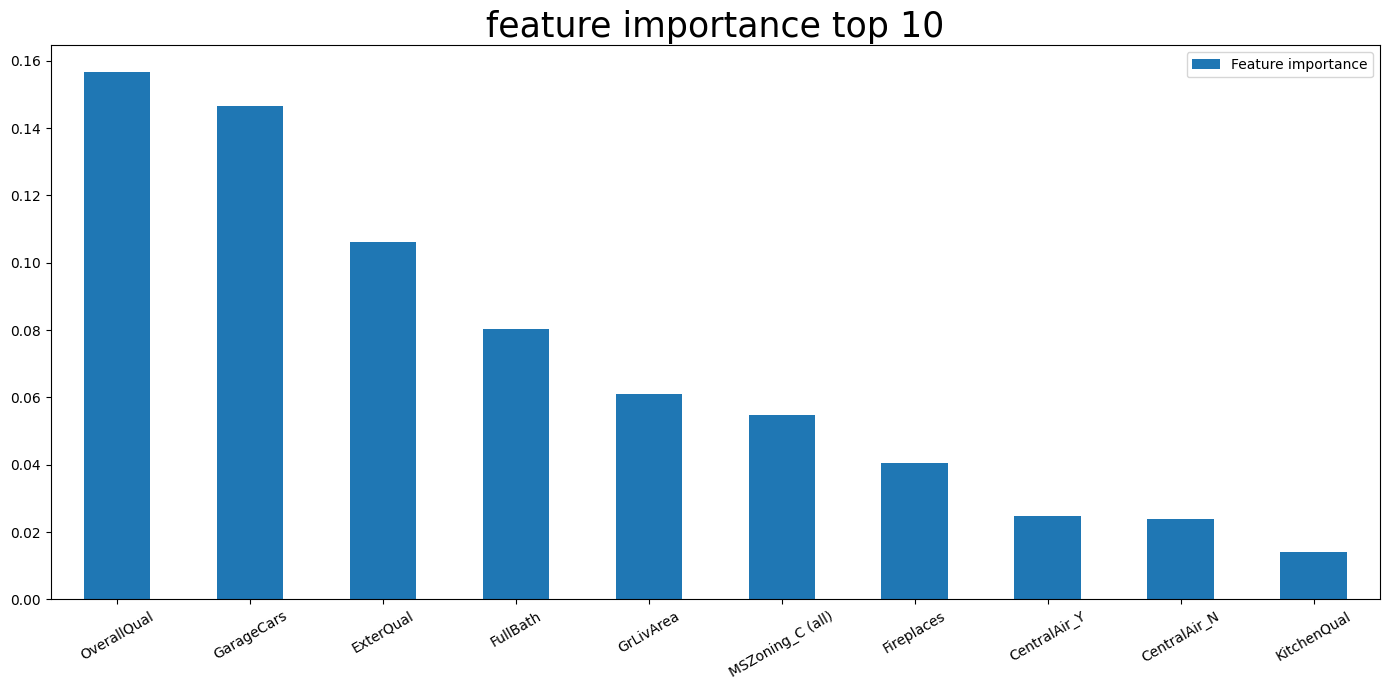

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
pd.DataFrame(xgbr.feature_importances_[np.argsort(xgbr.feature_importances_)[::-1][:10]],index=train_data.columns[np.argsort(xgbr.feature_importances_)[::-1][:10]],
             columns=['Feature importance']).plot(kind='bar',figsize=(14,7))
plt.title('feature importance top 10',fontsize=25)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()